In [1]:
import datetime
import pandas as pd
import Factor_classes

%load_ext autoreload
%autoreload 2

In [2]:
# se togli i seguenti ticker da Tickers.json, la strategia migliore diventa random forest:
#"IG.MI", "LDO.MI", "REC.MI",
#"STLAM.MI", "STMMI.MI", "TRN.MI", 
#"AZM.MI", "BPSO.MI", "ERG.MI"

In [3]:
start_date = datetime.datetime(2017, 1, 1)
end_date = datetime.datetime(2024, 1, 1)

stock_data = Factor_classes.StockData(start_date, end_date)
returns = stock_data.returns
index_returns = stock_data.index_returns

In [4]:
returns.tail(3)

Ticker,A2A.MI,AMP.MI,AZM.MI,BAMI.MI,BC.MI,BMED.MI,BMPS.MI,BPE.MI,BPSO.MI,CPR.MI,...,REC.MI,SPM.MI,SRG.MI,STLAM.MI,STMMI.MI,TEN.MI,TIT.MI,TRN.MI,UCG.MI,UNI.MI
Date,,,,,,,,,,,,,,,,,,,,,
2023-10-31,-0.036302,-0.057525,-0.034531,0.033469,-0.047368,-0.036450,-0.061018,0.036468,0.110658,-0.072374,...,-0.027754,-0.033333,-0.061186,0.065526,-0.057827,0.013154,0.028125,-0.053698,0.005291,-0.000776
2023-11-30,0.042084,-0.052874,-0.036249,0.063020,0.044890,-0.052813,0.064156,0.069334,0.051450,-0.068658,...,-0.024532,-0.008276,-0.032923,-0.009901,-0.115216,-0.021172,-0.170888,0.003616,0.042763,-0.006990
2023-12-31,0.117763,0.072312,0.120361,0.046110,0.004627,0.058610,0.217814,0.116129,0.108738,-0.040211,...,0.009145,0.023644,0.071792,0.110556,0.193681,0.081826,0.087169,0.026885,0.056572,0.035198


In [5]:
correlation_matrix = Factor_classes.CorrelationMatrix(returns)
#correlation_matrix.plot_heatmap()

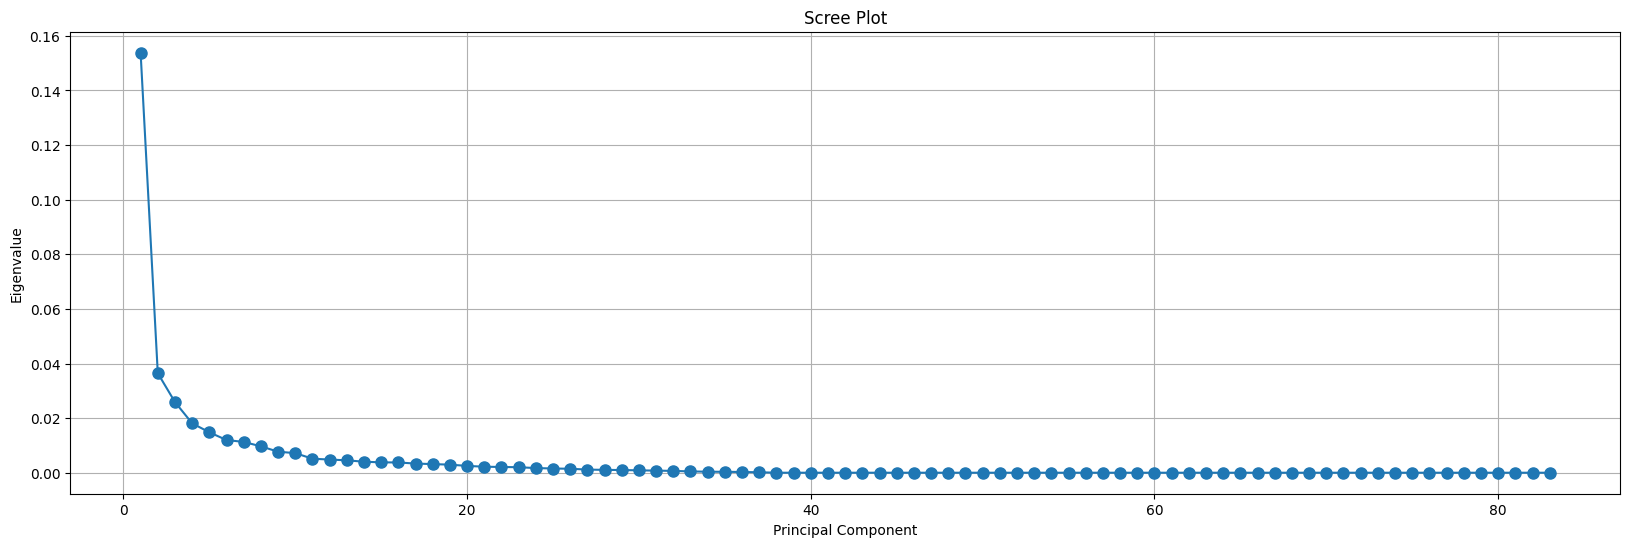

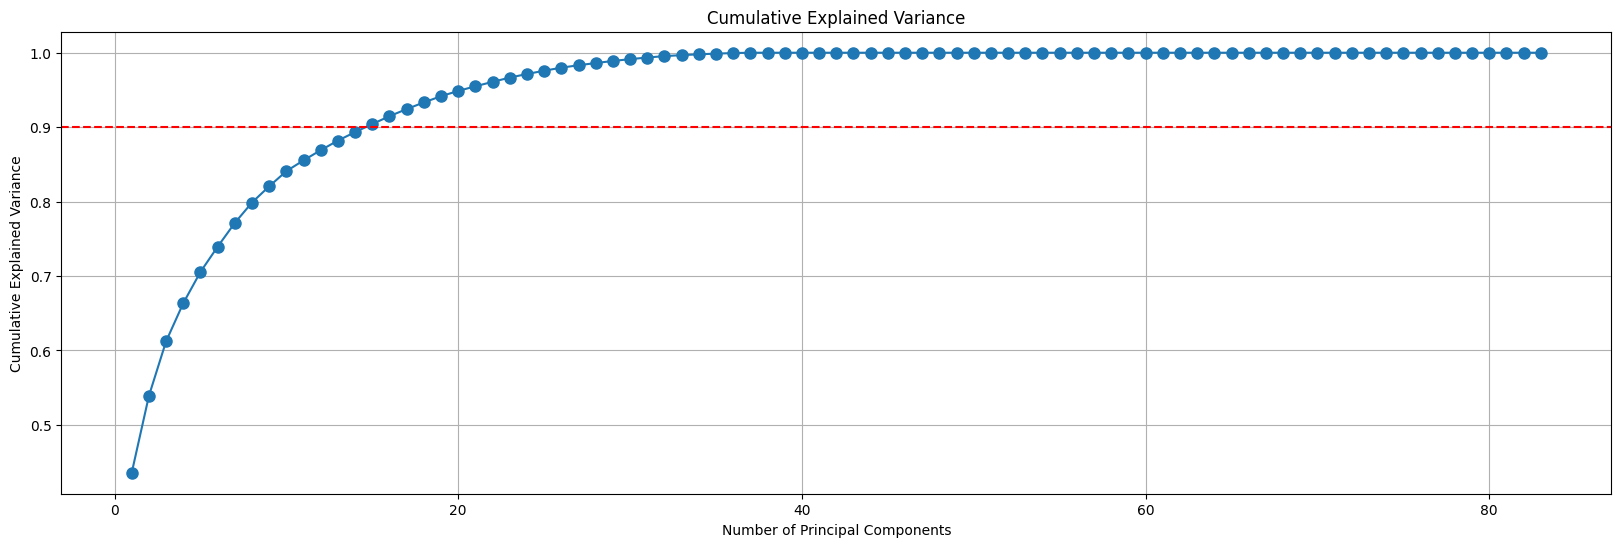

In [6]:
pca_analysis = Factor_classes.ComponentsAnalysis(stock_data.returns)
pca_analysis.plot_scree()
pca_analysis.plot_cumulative_explained_variance()

In [7]:
"""
m = 16 #explained variance 95
window_size = 36
max_iterations = 10000
factor_model = Factor_classes.APCA(returns, max_iterations=max_iterations)

U_m_final = factor_model.U_m_final
F_final = factor_model.F_final
B_final = factor_model.B_final
"""

'\nm = 16 #explained variance 95\nwindow_size = 36\nmax_iterations = 10000\nfactor_model = Factor_classes.APCA(returns, max_iterations=max_iterations)\n\nU_m_final = factor_model.U_m_final\nF_final = factor_model.F_final\nB_final = factor_model.B_final\n'

[[ 0.03804285 -0.00425473  0.00954902 ...  0.06254567 -0.01222192
  -0.01884793]
 [ 0.00197325  0.00051774  0.01911755 ... -0.00372334  0.01368972
   0.02448372]
 [-0.01411929 -0.01585505 -0.03755096 ... -0.00406911  0.00021568
  -0.00785919]
 ...
 [-0.02112741  0.01034635 -0.01823146 ...  0.00579627  0.02399309
   0.02141157]
 [-0.06330954  0.03791638  0.01832792 ... -0.01945796  0.03058239
   0.04171032]
 [ 0.01847781  0.02864468  0.01653874 ... -0.00469446  0.00263202
   0.0030165 ]]
[[-0.00785699  0.00705255 -0.00193855 ... -0.00325388 -0.01717957
   0.02172135]
 [ 0.04466207 -0.00575198  0.00037755 ...  0.02939972  0.03422866
  -0.07560218]
 [-0.02178416 -0.02430493 -0.01858214 ...  0.00100881 -0.00671659
   0.01527045]
 ...
 [ 0.00880353 -0.01289572 -0.00735321 ...  0.02285497  0.02361825
   0.0014891 ]
 [ 0.0483981   0.00950227  0.02197723 ...  0.02403522  0.04771395
  -0.01238102]
 [ 0.03803284 -0.00360117 -0.00412638 ...  0.00487751  0.00109941
  -0.00437044]]
[[ 0.00894552  0

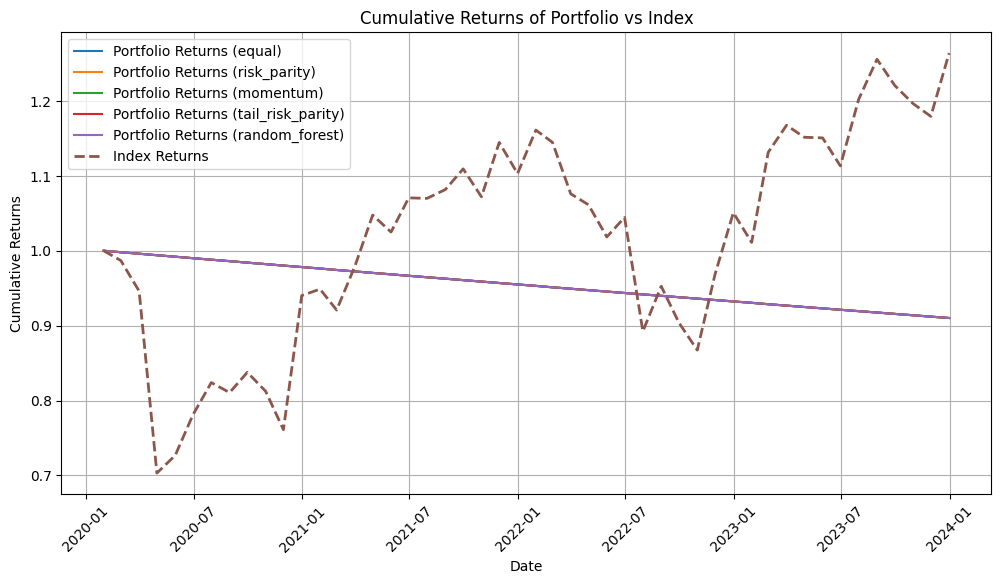

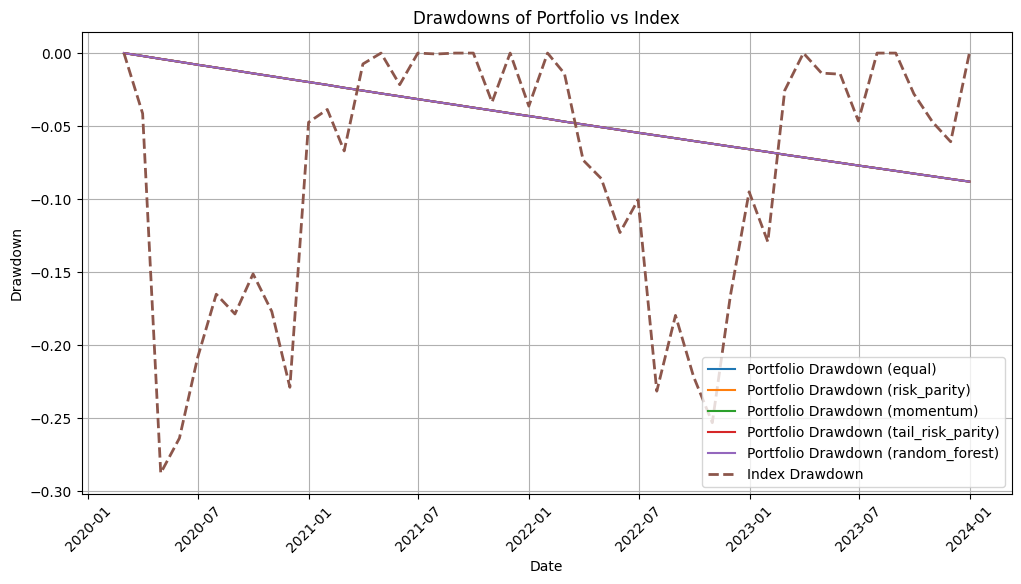

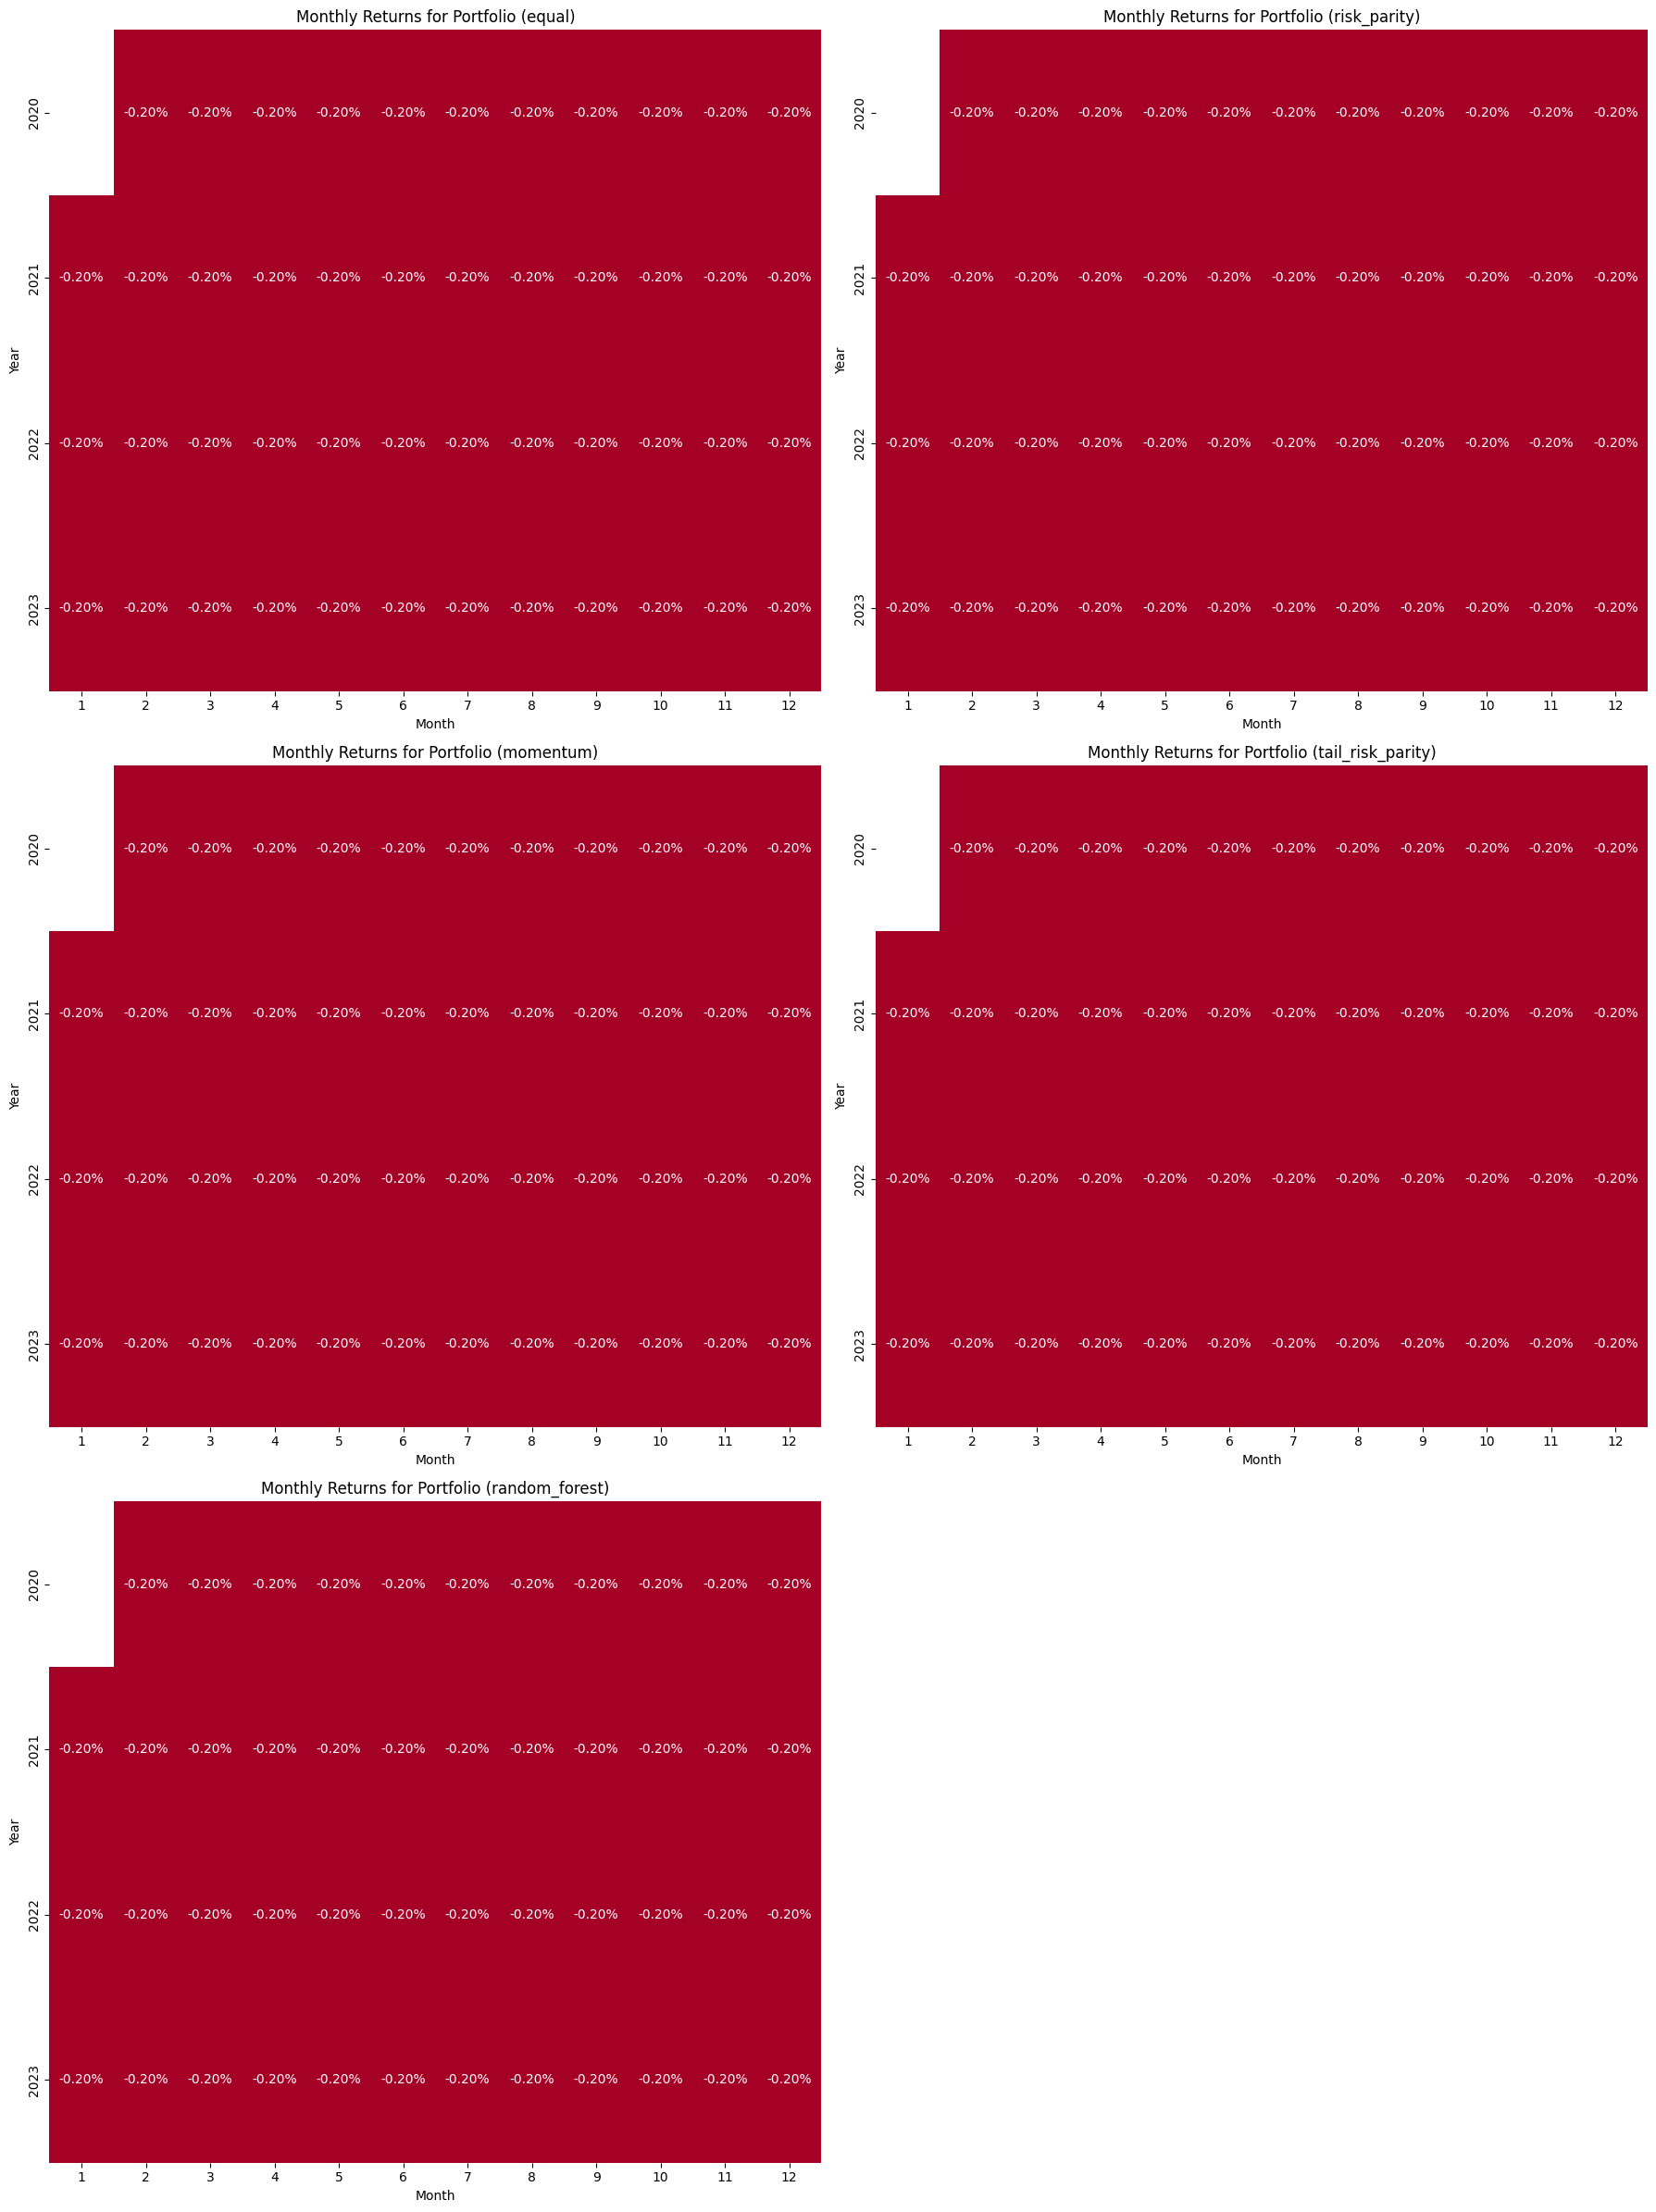

In [8]:
#con window size = 24, risultati ottimi con Random Forest
strategy = Factor_classes.RollingAPCAStrategy(returns, window_size=36, max_iterations=1000, transaction_cost=0.001, slippage=0.001)
index_cum_returns, portfolio_cum_returns = strategy.evaluate_strategies(index_returns)

In [9]:
index_test_rets = pd.DataFrame(index_cum_returns)
index_test_rets.rename(columns={'Open': 'Benchmark'}, inplace=True)

index_test_rets.head(3)

,Benchmark
Date,
2020-02-29,-0.013132
2020-03-31,-0.041379
2020-04-30,-0.256705


In [10]:
index_stats = Factor_classes.FinancialMetrics.summary_stats(index_test_rets)

index_stats

,Annualized Return,Annualized Volatility,Semi-Deviation,Skewness,Kurtosis,Historic VaR (5%),Cornish-Fisher VaR (5%),Historic CVaR (5%),Return on VaR,Sharpe Ratio,Sortino Ratio,Calmar Ratio,Modified Burke Ratio,Max Drawdown,Net Profit to Worst Drawdown,Beta,Treynor Ratio,Tracking Error,Information Ratio,Tail Ratio
Benchmark,0.0616,0.2548,0.1835,-0.3786,6.5755,0.0622,0.1144,0.1551,0.9912,0.1204,0.1672,0.1067,0.2562,-0.2875,0.9179,1,0,0,0,1.7226


In [11]:
portfolio_test_rets = pd.DataFrame(portfolio_cum_returns)

portfolio_test_rets.head(3)

,equal,risk_parity,momentum,tail_risk_parity,random_forest
2020-02-29,-0.002,-0.002,-0.002,-0.002,-0.002
2020-03-31,-0.002,-0.002,-0.002,-0.002,-0.002
2020-04-30,-0.002,-0.002,-0.002,-0.002,-0.002


In [12]:
portfolio_stats = Factor_classes.FinancialMetrics.summary_stats(portfolio_test_rets, market=index_test_rets)

portfolio_stats

,Annualized Return,Annualized Volatility,Semi-Deviation,Skewness,Kurtosis,Historic VaR (5%),Cornish-Fisher VaR (5%),Historic CVaR (5%),Return on VaR,Sharpe Ratio,Sortino Ratio,Calmar Ratio,Modified Burke Ratio,Max Drawdown,Net Profit to Worst Drawdown,Beta,Treynor Ratio,Tracking Error,Information Ratio,Tail Ratio
equal,-0.0237,0.0,0.0,-2.9193,12.8866,0.002,0.002,0.002,-11.8689,-3.354432e+14,-3.354432e+14,-0.5944,-1.0128,-0.088,-1.0207,-0.0,1.268670e+15,0.0736,-1.8881,-1.0
risk_parity,-0.0237,0.0,0.0,-3.0078,12.2705,0.002,0.002,0.002,-11.8689,-9.925608e+14,-9.901141e+14,-0.5944,-1.0128,-0.088,-1.0207,0.0,-1.356680e+15,0.0736,-1.8881,-1.0
momentum,-0.0237,0.0,0.0,-3.2458,13.6660,0.002,0.002,0.002,-11.8689,-8.764948e+14,-8.756143e+14,-0.5944,-1.0128,-0.088,-1.0207,0.0,-2.823434e+15,0.0736,-1.8881,-1.0
tail_risk_parity,-0.0237,0.0,0.0,-2.8323,11.5989,0.002,0.002,0.002,-11.8689,-1.133128e+15,-1.133180e+15,-0.5944,-1.0128,-0.088,-1.0207,0.0,-1.963201e+15,0.0736,-1.8881,-1.0
random_forest,-0.0237,0.0,0.0,-2.6796,9.8913,0.002,0.002,0.002,-11.8689,-1.084944e+15,-1.083002e+15,-0.5944,-1.0128,-0.088,-1.0207,0.0,-2.321607e+15,0.0736,-1.8881,-1.0


# To do

1. Controllare Random Forest
2. Provare diverse tecniche di ML
3. Ottimizzare window size